In [2]:
import numpy as np
import tensorflow as tf

from sklearn import datasets
from sklearn.model_selection import train_test_split

In [3]:
RANDOM_SEED = 42
tf.set_random_seed(RANDOM_SEED)


In [4]:
def init_weights(shape):
    """ Weight initialization """
    weights = tf.random_normal(shape, stddev=0.1)
    return tf.Variable(weights)

def forwardprop(X, w_1, w_2):
    """
    Forward-propagation.
    IMPORTANT: yhat is not softmax since TensorFlow's softmax_cross_entropy_with_logits() does that internally.
    """
    h    = tf.nn.sigmoid(tf.matmul(X, w_1))  # The \sigma function
    yhat = tf.matmul(h, w_2)  # The \varphi function
    return yhat

def get_iris_data():
    """ Read the iris data set and split them into training and test sets """
    iris   = datasets.load_iris()
    data   = iris["data"]
    target = iris["target"]

    # Prepend the column of 1s for bias
    N, M  = data.shape
    all_X = np.ones((N, M + 1))
    all_X[:, 1:] = data

    # Convert into one-hot vectors
    num_labels = len(np.unique(target))
    all_Y = np.eye(num_labels)[target]  # One liner trick!
    return train_test_split(all_X, all_Y, test_size=0.33, random_state=RANDOM_SEED)

In [5]:
def main():
    train_X, test_X, train_y, test_y = get_iris_data()

    # Layer's sizes
    x_size = train_X.shape[1]   # Number of input nodes: 4 features and 1 bias
    h_size = 256                # Number of hidden nodes
    y_size = train_y.shape[1]   # Number of outcomes (3 iris flowers)

    # Symbols
    X = tf.placeholder("float", shape=[None, x_size])
    y = tf.placeholder("float", shape=[None, y_size])

    # Weight initializations
    w_1 = init_weights((x_size, h_size))
    w_2 = init_weights((h_size, y_size))

    # Forward propagation
    yhat    = forwardprop(X, w_1, w_2)
    predict = tf.argmax(yhat, axis=1)

    # Backward propagation
    cost    = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=yhat))
    updates = tf.train.GradientDescentOptimizer(0.01).minimize(cost)

    # Run SGD
    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)

    for epoch in range(100):
        # Train with each example
        for i in range(len(train_X)):
            sess.run(updates, feed_dict={X: train_X[i: i + 1], y: train_y[i: i + 1]})

        train_accuracy = np.mean(np.argmax(train_y, axis=1) ==
                                 sess.run(predict, feed_dict={X: train_X, y: train_y}))
        test_accuracy  = np.mean(np.argmax(test_y, axis=1) ==
                                 sess.run(predict, feed_dict={X: test_X, y: test_y}))

        print("Epoch = %d, train accuracy = %.2f%%, test accuracy = %.2f%%"
              % (epoch + 1, 100. * train_accuracy, 100. * test_accuracy))

    sess.close()

In [6]:
if __name__ == '__main__':
    main()

Epoch = 1, train accuracy = 65.00%, test accuracy = 70.00%
Epoch = 2, train accuracy = 65.00%, test accuracy = 70.00%
Epoch = 3, train accuracy = 68.00%, test accuracy = 70.00%
Epoch = 4, train accuracy = 70.00%, test accuracy = 70.00%
Epoch = 5, train accuracy = 71.00%, test accuracy = 74.00%
Epoch = 6, train accuracy = 72.00%, test accuracy = 76.00%
Epoch = 7, train accuracy = 77.00%, test accuracy = 78.00%
Epoch = 8, train accuracy = 80.00%, test accuracy = 78.00%
Epoch = 9, train accuracy = 83.00%, test accuracy = 78.00%
Epoch = 10, train accuracy = 83.00%, test accuracy = 78.00%
Epoch = 11, train accuracy = 85.00%, test accuracy = 78.00%
Epoch = 12, train accuracy = 87.00%, test accuracy = 78.00%
Epoch = 13, train accuracy = 87.00%, test accuracy = 78.00%
Epoch = 14, train accuracy = 87.00%, test accuracy = 78.00%
Epoch = 15, train accuracy = 87.00%, test accuracy = 82.00%
Epoch = 16, train accuracy = 88.00%, test accuracy = 84.00%
Epoch = 17, train accuracy = 88.00%, test accurac

# Partial Differentil Equation

## Imports & setups

In [7]:
import numpy as np
import tensorflow as tf

import PIL.Image
from io import BytesIO
from IPython.display import clear_output, Image, display

In [8]:
def DisplayArray(a, fmt='jpeg', rng=[0,1]):
  """Display an array as a picture."""
  a = (a - rng[0])/float(rng[1] - rng[0])*255
  a = np.uint8(np.clip(a, 0, 255))
  f = BytesIO()
  PIL.Image.fromarray(a).save(f, fmt)
  clear_output(wait = True)
  display(Image(data=f.getvalue()))

In [9]:
sess = tf.InteractiveSession()

# Computational Convenience Functions

In [10]:
def make_kernel(a):
  """Transform a 2D array into a convolution kernel"""
  a = np.asarray(a)
  a = a.reshape(list(a.shape) + [1,1])
  return tf.constant(a, dtype=1)

def simple_conv(x, k):
  """A simplified 2D convolution operation"""
  x = tf.expand_dims(tf.expand_dims(x, 0), -1)
  y = tf.nn.depthwise_conv2d(x, k, [1, 1, 1, 1], padding='SAME')
  return y[0, :, :, 0]

def laplace(x):
  """Compute the 2D laplacian of an array"""
  laplace_k = make_kernel([[0.5, 1.0, 0.5],
                           [1.0, -6., 1.0],
                           [0.5, 1.0, 0.5]])
  return simple_conv(x, laplace_k)


## Define the PDE

In [15]:
N = 500

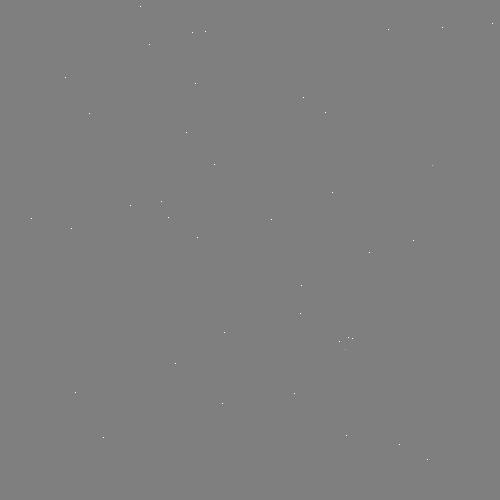

In [16]:
# Initial Conditions -- some rain drops hit a pond

# Set everything to zero
u_init = np.zeros([N, N], dtype=np.float32)
ut_init = np.zeros([N, N], dtype=np.float32)

# Some rain drops hit a pond at random points
for n in range(40):
  a,b = np.random.randint(0, N, 2)
  u_init[a,b] = np.random.uniform()

DisplayArray(u_init, rng=[-0.1, 0.1])

### Now let's specify the details of the differential equation.

In [17]:
# Parameters:
# eps -- time resolution
# damping -- wave damping
eps = tf.placeholder(tf.float32, shape=())
damping = tf.placeholder(tf.float32, shape=())

# Create variables for simulation state
U  = tf.Variable(u_init)
Ut = tf.Variable(ut_init)

# Discretized PDE update rules
U_ = U + eps * Ut
Ut_ = Ut + eps * (laplace(U) - damping * Ut)

# Operation to update the state
step = tf.group(
  U.assign(U_),
  Ut.assign(Ut_))


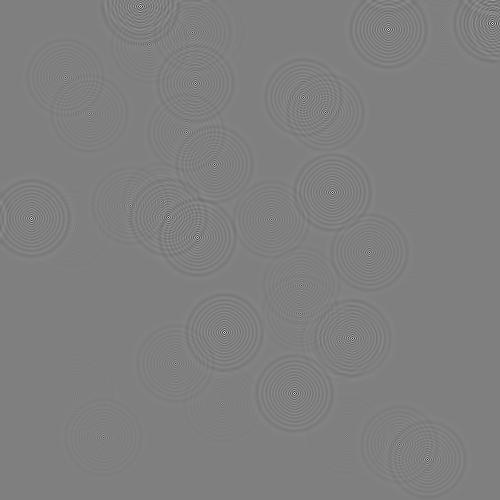

In [18]:
# Initialize state to initial conditions
tf.global_variables_initializer().run()

# Run 1000 steps of PDE
for i in range(1000):
  # Step simulation
  step.run({eps: 0.03, damping: 0.04})
  DisplayArray(U.eval(), rng=[-0.1, 0.1])